In [1]:
# --- Célula 1: Importações ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

# Pré-processamento
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

# Métricas
from sklearn.metrics import classification_report, confusion_matrix

# Salvamento de objetos
import joblib

2025-10-15 22:28:16.416175: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-15 22:28:16.552969: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-15 22:28:16.588208: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-15 22:28:16.829243: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-15 22:28:18.054834: W tensorflow/compiler/tf2

In [2]:
# --- Célula 2: Carregamento dos Dados ---
path_final_table = '../data/processed/modeling_table_final.parquet'
df_completo = pd.read_parquet(path_final_table)

print(f"Dados carregados: {df_completo.shape[0]} dias, {df_completo.shape[1]} colunas.")
print(f"Período: {df_completo.index.min().date()} a {df_completo.index.max().date()}")

Dados carregados: 5693 dias, 29 colunas.
Período: 2010-02-10 a 2025-09-11


In [3]:
# --- Célula 3: Definição de Features ---
features_carga = ['programada', 'verificada', 'diferenca_verif_prog']
features_geracao = ['geracao_total_diaria_go', 'geracao_fotovoltaica_diaria', 'geracao_hidroelétrica_diaria', 'geracao_térmica_diaria']
features_rede = ['total_mwh_restrito_go', 'saldo_intercambio_seco']
features_hidrica = ['ear_percentual_seco', 'ena_percentual_mlt_seco']
features_adicionais = ['cmo_semanal_seco', 'disponibilidade_total_diaria_go']
features_clima = ['ghi', 'temp2m_c', 'precipitacao_mm']
features_avancadas = ['carga_media_7d','carga_std_7d','geracao_media_7d','ear_ontem','ear_diff_3d','margem_oferta_demanda','pressao_demanda_ear','precip_acumulada_14d','precip_acumulada_30d']
features_calendario = ['mes','dia_da_semana','dia_do_ano']

print("Grupos de features definidos com sucesso.")

Grupos de features definidos com sucesso.


In [4]:
# --- Célula 4: Painel de Controle, Cenário e Filtragem ---
import sys
sys.path.append('..')
from config import END_YEAR

# --- ESCOLHA O CENÁRIO PARA TESTAR ---
# Opções: 'pos_2022', 'pos_2020', 'pos_2017', 'pos_2015', 'pos_2013', 'pos_2010'
CENARIO_ESCOLHIDO = 'pos_2015'
# -------------------------------------

# Define o período de análise e as features com base no cenário escolhido
if CENARIO_ESCOLHIDO == 'pos_2022':
    START_YEAR = 2022
    nome_cenario = "LSTM Pós-2022 (Features de Geração)"
    features_para_teste_nomes = (
        features_geracao + 
        features_rede + 
        features_hidrica +
        features_adicionais + 
        features_clima + 
        features_calendario +
        features_avancadas + 
        ['programada'] 
    )
elif CENARIO_ESCOLHIDO == 'pos_2020':
    START_YEAR = 2020
    nome_cenario = "LSTM Pós-2020 (Histórico com Carga Prog.)"
    features_para_teste_nomes = (
        features_hidrica + 
        features_adicionais + 
        features_clima +
        features_calendario + 
        features_avancadas + 
        ['programada']
    )
elif CENARIO_ESCOLHIDO == 'pos_2017':
    START_YEAR = 2017
    nome_cenario = "LSTM Pós-2017 (Histórico Intermediário)"
    features_para_teste_nomes = (
        features_hidrica + 
        features_adicionais + 
        features_clima +
        features_calendario + 
        features_avancadas
    )
elif CENARIO_ESCOLHIDO == 'pos_2015':
    START_YEAR = 2015
    nome_cenario = "LSTM Pós-2015 (Histórico com Disponibilidade)"
    features_para_teste_nomes = (
        features_hidrica + 
        features_adicionais + 
        features_clima +
        features_calendario + 
        features_avancadas
    )
elif CENARIO_ESCOLHIDO == 'pos_2013':
    START_YEAR = 2013
    nome_cenario = "LSTM Pós-2013 (Histórico Extendido Básico)"
    features_para_teste_nomes = (
        features_hidrica + 
        features_clima + 
        features_calendario + 
        features_avancadas + 
        ['cmo_semanal_seco', 'indicador_ccal_mensal']
    )
elif CENARIO_ESCOLHIDO == 'pos_2010':
    START_YEAR = 2010
    nome_cenario = "LSTM Pós-2010 (Máximo Histórico Básico)"
    features_para_teste_nomes = (
        features_hidrica + 
        features_clima + 
        features_calendario + 
        features_avancadas + 
        ['cmo_semanal_seco', 'indicador_ccal_mensal']
    )
else:
    raise ValueError("Cenário escolhido é inválido.")

print(f"--- INICIANDO EXPERIMENTO COM O CENÁRIO: '{nome_cenario}' ---")

# Filtra o período
anos_de_interesse = range(START_YEAR, END_YEAR + 1)
df = df_completo[df_completo.index.year.isin(anos_de_interesse)].copy()
features_para_teste = [col for col in features_para_teste_nomes if col in df.columns]
X = df[features_para_teste]
y = df['nivel_risco']

print(f"\nPeríodo de análise: de {df.index.min().date()} a {df.index.max().date()}")
print(f"Número de features selecionadas: {len(X.columns)}")
print(f"\nAmostragem de classes no dataset deste cenário:")
print(y.value_counts())

--- INICIANDO EXPERIMENTO COM O CENÁRIO: 'LSTM Pós-2015 (Histórico com Disponibilidade)' ---

Período de análise: de 2015-01-01 a 2025-09-11
Número de features selecionadas: 16

Amostragem de classes no dataset deste cenário:
nivel_risco
baixo    3707
alto      103
medio      97
Name: count, dtype: int64


In [5]:
# --- Célula 5: Pré-processamento e Sequências ---
mapeamento_risco = {'baixo':0,'medio':1,'alto':2}
y_encoded = y.map(mapeamento_risco)

# Split temporal
test_size = 0.2
split_index = int(len(X)*(1-test_size))
X_train_full = X[:split_index]
y_train_full = y_encoded[:split_index]
X_test = X[split_index:]
y_test = y_encoded[split_index:]

# Escalonamento
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test)

# Função para criar sequências
def create_sequences(X, y, time_steps=14):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 14
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_full.values, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, TIME_STEPS)

print("Formato X_train_seq:", X_train_seq.shape)
print("Formato X_test_seq:", X_test_seq.shape)

Formato X_train_seq: (3111, 14, 16)
Formato X_test_seq: (768, 14, 16)


In [6]:
# --- Célula 6: Oversampling + Tuner (versão original mais detalhada) ---
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(
    X_train_seq.reshape(X_train_seq.shape[0], -1), y_train_seq
)
X_res = X_res.reshape(-1, X_train_seq.shape[1], X_train_seq.shape[2])

def build_model(hp):
    model = Sequential()
    
    # Camada LSTM 1 (Bidirectional)
    hp_units_1 = hp.Int('units_1', min_value=64, max_value=256, step=64)
    hp_dropout_1 = hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)
    model.add(Bidirectional(LSTM(units=hp_units_1, return_sequences=True), input_shape=(X_res.shape[1], X_res.shape[2])))
    model.add(Dropout(hp_dropout_1))
    
    # Camada LSTM 2
    hp_units_2 = hp.Int('units_2', min_value=32, max_value=128, step=32)
    hp_dropout_2 = hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)
    model.add(Bidirectional(LSTM(units=hp_units_2, return_sequences=True)))
    model.add(Dropout(hp_dropout_2))
    
    # Camada LSTM 3
    hp_units_3 = hp.Int('units_3', min_value=16, max_value=64, step=16)
    hp_dropout_3 = hp.Float('dropout_3', min_value=0.2, max_value=0.5, step=0.1)
    model.add(LSTM(units=hp_units_3))
    model.add(Dropout(hp_dropout_3))
    
    # Camadas Dense finais
    hp_dense_1 = hp.Int('dense_1', min_value=32, max_value=128, step=32)
    hp_dense_2 = hp.Int('dense_2', min_value=16, max_value=64, step=16)
    model.add(Dense(units=hp_dense_1, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(units=hp_dense_2, activation='relu'))
    
    # Saída
    model.add(Dense(3, activation='softmax'))

    # Compilação
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective("val_accuracy", direction="max"),
    max_trials=10,
    executions_per_trial=2,
    directory='keras_tuner_dir',
    project_name=f'lstm_tuning_advanced_{CENARIO_ESCOLHIDO}',
    overwrite=True
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
tuner.search(X_res, y_res, epochs=50, validation_split=0.2, callbacks=[early_stopping], verbose=1)


Trial 10 Complete [00h 08m 51s]
val_accuracy: 0.9512194991111755

Best val_accuracy So Far: 1.0
Total elapsed time: 01h 06m 48s


/home/paulo/Code/ons-risk-prediction/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 48 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Resultados finais LSTM - LSTM Pós-2015 (Histórico com Disponibilidade)
              precision    recall  f1-score   support

       baixo       0.97      0.85      0.91       741
       medio       0.06      0.07      0.06        15
        alto       0.03      0.25      0.05        12

    accuracy                           0.83       768
   macro avg       0.35      0.39      0.34       768
weighted avg       0.94      0.83      0.88       768



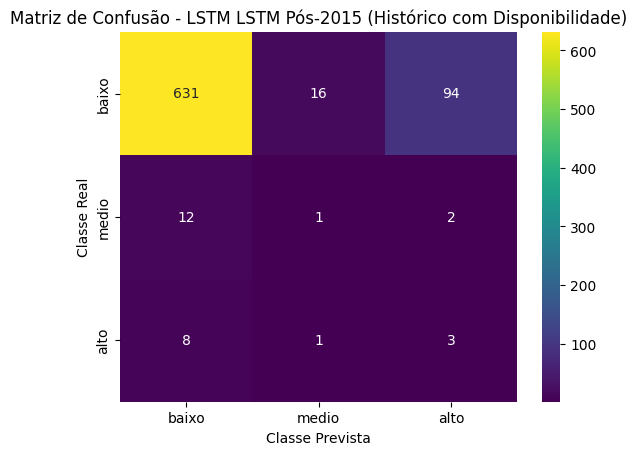

Modelo e scaler LSTM salvos com sucesso!


In [7]:
# --- Célula 7: Avaliação + Salvamento ---
best_model = tuner.get_best_models(1)[0]

# Previsão
y_pred_proba = best_model.predict(X_test_seq)
y_pred = np.argmax(y_pred_proba, axis=1)

print(f"\nResultados finais LSTM - {nome_cenario}")
print(classification_report(y_test_seq, y_pred, target_names=mapeamento_risco.keys(), zero_division=0))

# Matriz de confusão
cm = confusion_matrix(y_test_seq, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=mapeamento_risco.keys(), yticklabels=mapeamento_risco.keys())
plt.title(f'Matriz de Confusão - LSTM {nome_cenario}')
plt.ylabel('Classe Real'); plt.xlabel('Classe Prevista'); plt.show()

# Salvamento
os.makedirs('../models', exist_ok=True)
best_model.save(f'../models/best_lstm_model_{CENARIO_ESCOLHIDO}.h5')
joblib.dump(scaler, f'../models/scaler_lstm_{CENARIO_ESCOLHIDO}.joblib')
print("Modelo e scaler LSTM salvos com sucesso!")